In [1]:
import sys
import os
import pandas as pd
import numpy as np

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt

import matplotlib.pylab as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

import warnings
warnings.filterwarnings('ignore')

### ARIMA
<code>pip install statsmodels</code><br>
tutorial: https://github.com/SimiY/pydata-sf-2016-arima-tutorial

In [2]:
sentiment = pd.read_csv('data/sentiment.csv',
                       index_col=0, parse_dates=[0])
sentiment.head()

,UMCSENT
DATE,
2000-01-01,112.0
2000-02-01,111.3
2000-03-01,107.1
2000-04-01,109.2
2000-05-01,110.7


In [3]:
sentiment_short = sentiment.loc['2005':'2016']

### 差分 diff
<code>df[col].diff(int)</code>

In [4]:
sentiment_short['UMCSENT_diff1'] = sentiment_short['UMCSENT'].diff(1)
sentiment_short['UMCSENT_diff2'] = sentiment_short['UMCSENT'].diff(2)

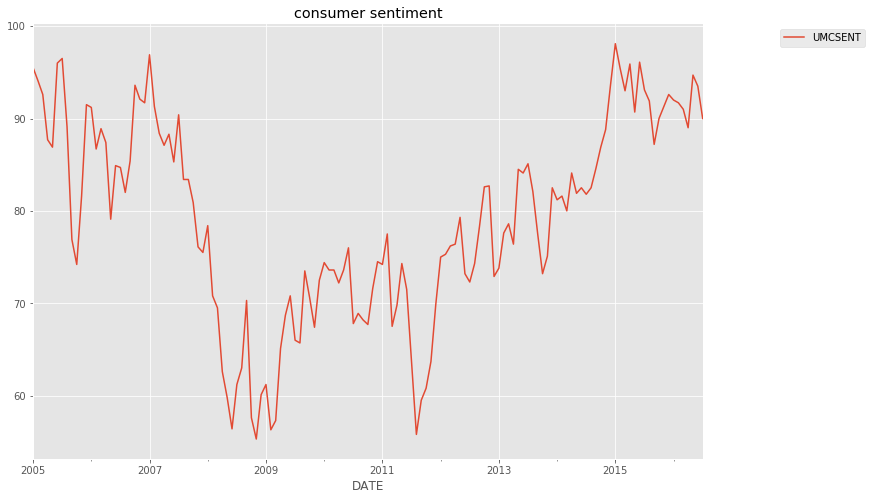

In [5]:
fig = plt.figure(figsize=(12,8))

sentiment_short['UMCSENT'].plot(figsize=(12,8))
plt.legend(bbox_to_anchor=(1.25, 1))
plt.title('consumer sentiment')

sns.despine()

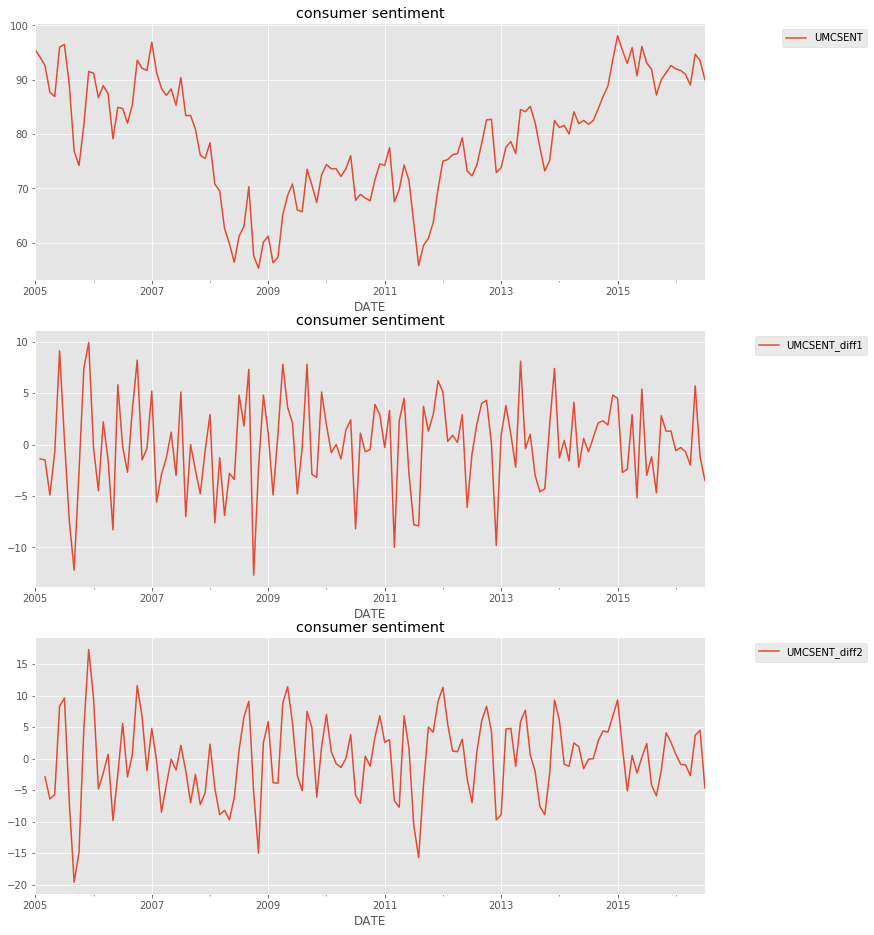

In [6]:
""" 原數據
    一階差分
    二階差分
"""
fig = plt.figure(figsize=(12,16))

ax1 = fig.add_subplot(311)
sentiment_short['UMCSENT'].plot()
plt.legend(bbox_to_anchor=(1.25, 1))
plt.title('consumer sentiment')

ax2 = fig.add_subplot(312)
sentiment_short['UMCSENT_diff1'].plot()
plt.legend(bbox_to_anchor=(1.25, 1))
plt.title('consumer sentiment')

ax3 = fig.add_subplot(313)
sentiment_short['UMCSENT_diff2'].plot()
plt.legend(bbox_to_anchor=(1.25, 1))
plt.title('consumer sentiment')
sns.despine()

### ACF與 PACF

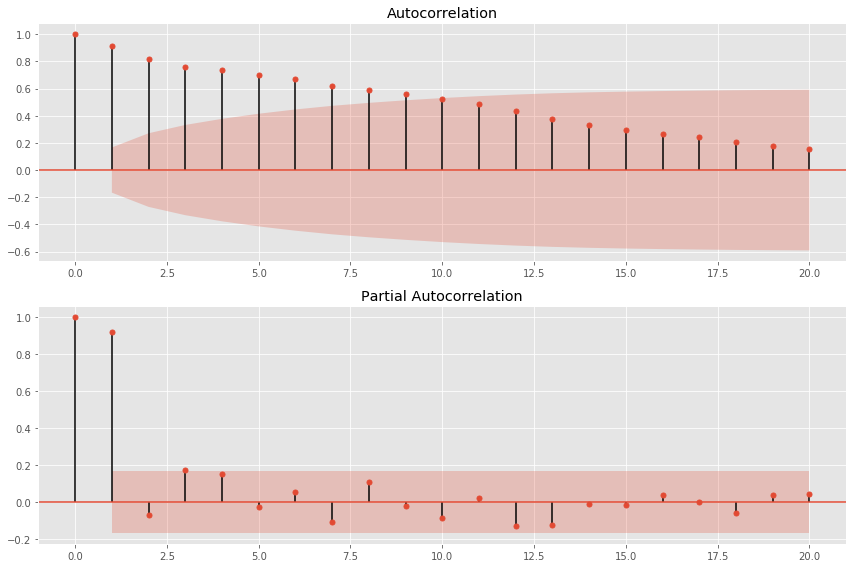

In [7]:
fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(211) # 2X1網格,第1子圖
fig = sm.graphics.tsa.plot_acf(sentiment_short['UMCSENT'], lags=20, ax=ax1)
ax1.xaxis.set_ticks_position('bottom')
fig.tight_layout()

ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(sentiment_short['UMCSENT'], lags=20, ax=ax2)
ax2.xaxis.set_ticks_position('bottom')
fig.tight_layout()

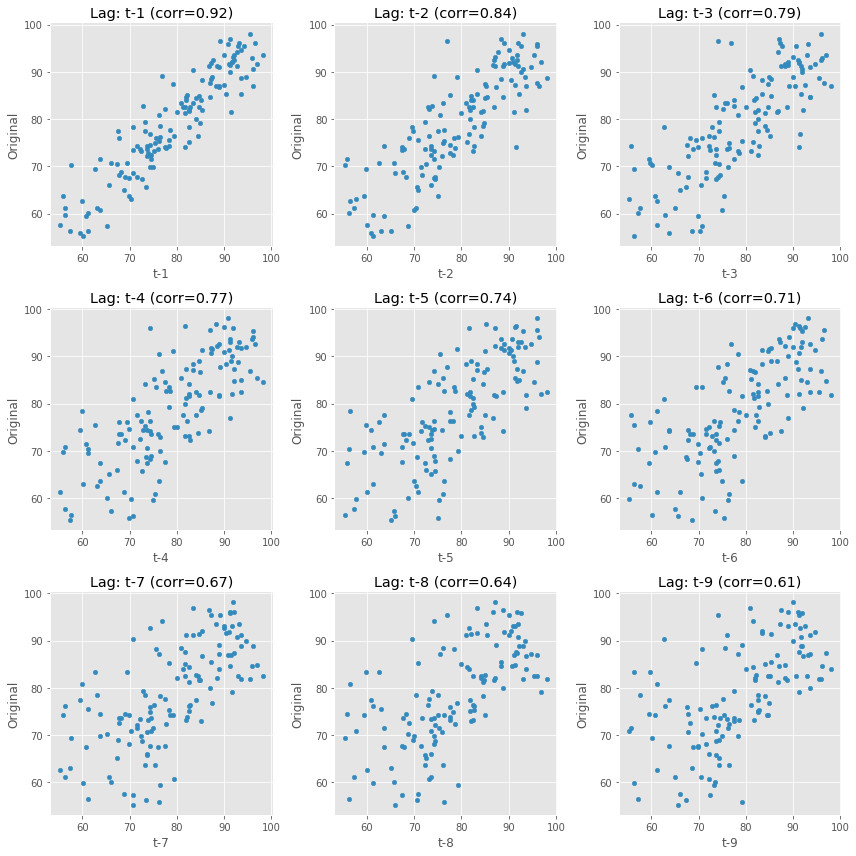

In [8]:
""" 自相關的散點圖
"""

lags=9

ncols=3
nrows=int(np.ceil(lags/ncols))

fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(4*ncols, 4*nrows))

for ax, lag in zip(axes.flat, np.arange(1,lags+1, 1)):
    lag_str = 't-{}'.format(lag)
    X = (pd.concat([sentiment_short['UMCSENT'], sentiment_short['UMCSENT'].shift(-lag)], axis=1,
                   keys=['y'] + [lag_str]).dropna())

    X.plot(ax=ax, kind='scatter', y='y', x=lag_str);
    corr = X.corr().as_matrix()[0][1]
    ax.set_ylabel('Original')
    ax.set_title('Lag: {} (corr={:.2f})'.format(lag_str, corr));
    ax.set_aspect('equal');
    sns.despine();

fig.tight_layout();

In [9]:
def tsplot(y, lags=None, title='', figsize=(14, 8)):
    '''Examine the patterns of ACF and PACF, along with the time series plot and histogram.
    
    Original source: https://tomaugspurger.github.io/modern-7-timeseries.html
    '''
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax   = plt.subplot2grid(layout, (0, 0))
    hist_ax = plt.subplot2grid(layout, (0, 1))
    acf_ax  = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
    
    y.plot(ax=ts_ax)
    ts_ax.set_title(title)
    y.plot(ax=hist_ax, kind='hist', bins=25)
    hist_ax.set_title('Histogram')
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    [ax.set_xlim(0) for ax in [acf_ax, pacf_ax]]
    sns.despine()
    plt.tight_layout()
    
    return ts_ax, acf_ax, pacf_ax

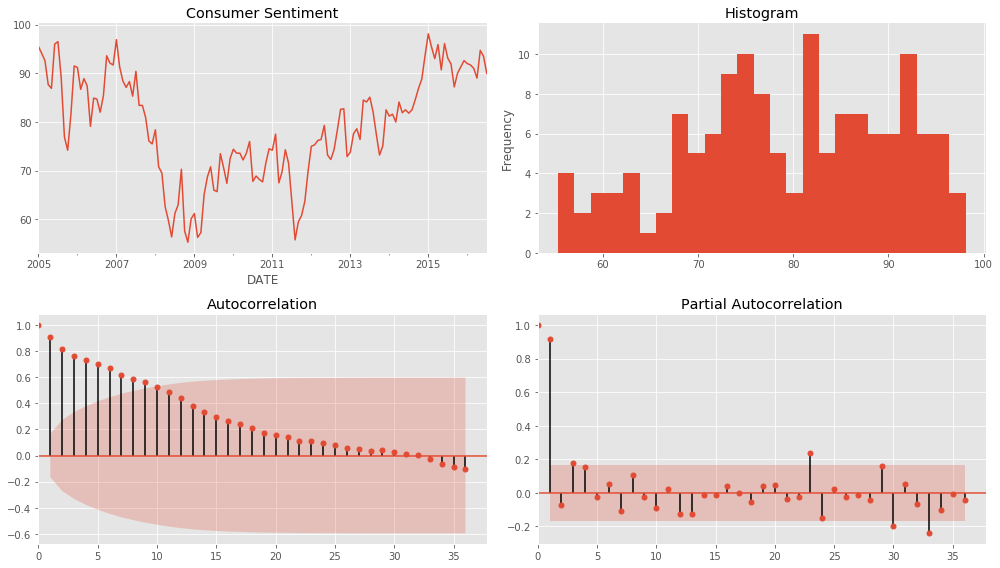

In [10]:
tsplot(sentiment_short['UMCSENT'], title='Consumer Sentiment', lags=36);

### ARIMA(p, d, q)
1. p: AR(p), 看PACF截尾, ACF趨於0
2. q: MA(q), 看ACF截尾, PACF趨於0
<br>
截尾: 落在信心區間內
3. d: diff, 幾階方差

In [11]:
ts_df = pd.read_csv('data/series1.csv', index_col=0, parse_dates=[0])

In [12]:
""" 建立train & test
"""
n_sample = ts_df.shape[0]
n_train = int(0.95 * n_sample) + 1
n_forecast = n_sample - n_train

ts_train = ts_df.iloc[:n_train]['value']
ts_test = ts_df.iloc[n_train:]['value']
print(ts_train.shape)
print(ts_test.shape)

(115,)
(5,)


(<matplotlib.axes._subplots.AxesSubplot at 0x2872273cef0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x287226f40b8>)

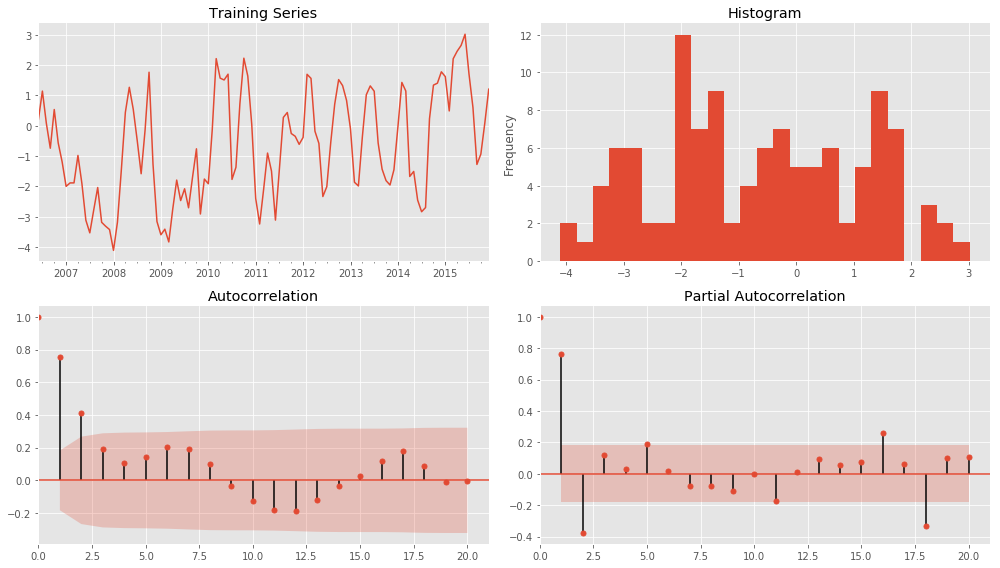

In [13]:
tsplot(ts_train, title='Training Series', lags=20)

In [14]:
""" fit the model
    order: p, d, q
"""
arima200 = sm.tsa.SARIMAX(ts_train, order=(2,0,0))
model_results = arima200.fit()                          

### AIC與 BIC
* 使用AIC與BIC選擇更簡單的模型, 越低越好
1. AIC赤池信息準則: $AIC = 2k - 2ln(L)$
2. BIC貝葉斯信息準則: $BIC = kln(n) - 2ln(L)$
3. $k$ 模型參數個數, $n$ 樣本數, $L$ 依然函數

In [15]:
import itertools

In [16]:
p_min = 0
d_min = 0
q_min = 0
p_max = 4
d_max = 0
q_max = 4

results_bic = pd.DataFrame(index=['AR{}'.format(i) for i in range(p_min, p_max + 1)],
                           columns=['MA{}'.format(i) for i in range(q_min, q_max + 1)])

for p, d, q in itertools.product(range(p_min,p_max + 1),
                                 range(d_min,d_max + 1),
                                 range(q_min,q_max + 1)):
    if p==0 and d==0 and q==0:
        results_bic.loc['AR{}'.format(p), 'MA{}'.format(q)] = np.nan
        continue
    
    try:
        model = sm.tsa.SARIMAX(ts_train, order=(p, d, q))
        results = model.fit()
        results_bic.loc['AR{}'.format(p), 'MA{}'.format(q)] = results.bic
    except:
        continue
results_bic = results_bic[results_bic.columns].astype(float)

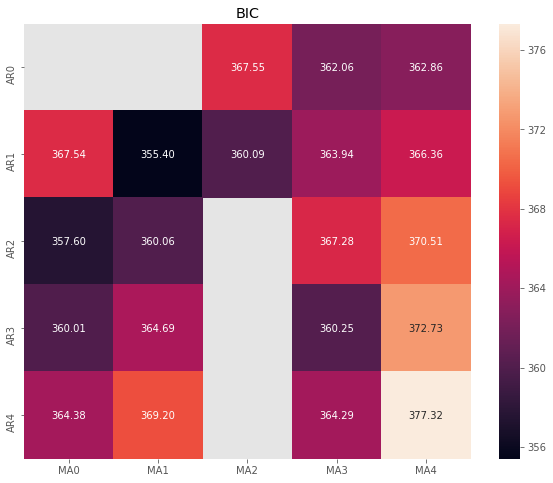

In [17]:
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(results_bic,
                 mask=results_bic.isnull(),
                 ax=ax,
                 annot=True,
                 fmt='.2f',
                 );
ax.set_title('BIC');

In [18]:
train_results = sm.tsa.arma_order_select_ic(ts_train, ic=['aic', 'bic'], trend='nc', max_ar=4, max_ma=4)

print('AIC', train_results.aic_min_order)
print('BIC', train_results.bic_min_order)

AIC (4, 2)
BIC (1, 1)


### 模型殘差檢驗:
* ARIMA模型的殘差是否是平均值為0且方差為常數的常態分布
* QQ圖: 線性即常態分布

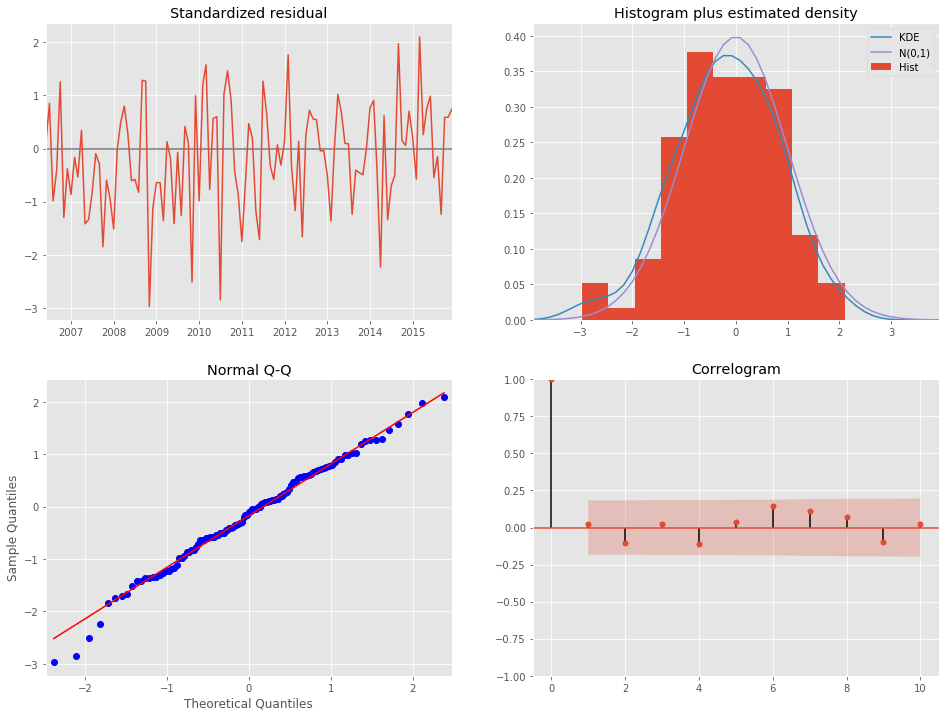

In [19]:
model_results.plot_diagnostics(figsize=(16, 12));

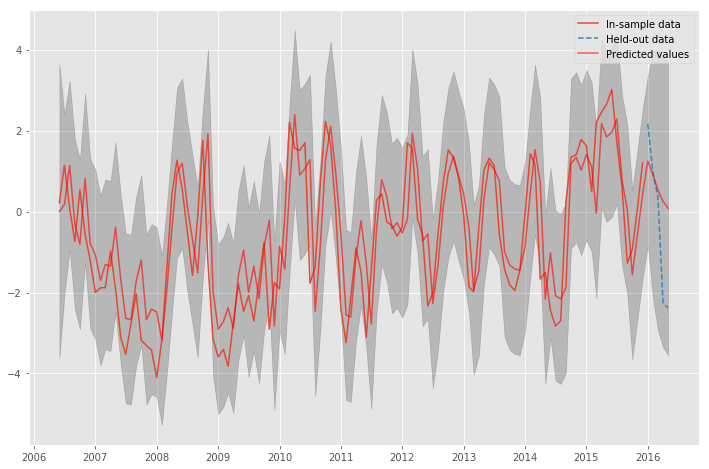

In [20]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
    
ax1.plot(ts_train, label='In-sample data', linestyle='-')
# subtract 1 only to connect it to previous point in the graph
ax1.plot(ts_test, label='Held-out data', linestyle='--')

# yes DatetimeIndex
pred_begin = ts_train.index[model_results.loglikelihood_burn]
pred_end = ts_test.index[-1]
pred = model_results.get_prediction(start=pred_begin.strftime('%Y-%m-%d'),
                                    end=pred_end.strftime('%Y-%m-%d'))
pred_mean = pred.predicted_mean
pred_ci = pred.conf_int(alpha=0.05)

ax1.plot(pred_mean, 'r', alpha=.6, label='Predicted values')
ax1.fill_between(pred_ci.index,
                 pred_ci.iloc[:, 0],
                 pred_ci.iloc[:, 1], color='k', alpha=.2)

ax1.legend(loc='best');

In [21]:
def get_rmse(y, y_hat):
    '''Root Mean Square Error
    https://en.wikipedia.org/wiki/Root-mean-square_deviation
    '''
    mse = np.mean((y - y_hat)**2)
    return np.sqrt(mse)

def get_mape(y, y_hat):
    '''Mean Absolute Percent Error
    https://en.wikipedia.org/wiki/Mean_absolute_percentage_error
    '''
    perc_err = (100*(y - y_hat))/y
    return np.mean(abs(perc_err))

def get_mase(y, y_hat):
    '''Mean Absolute Scaled Error
    https://en.wikipedia.org/wiki/Mean_absolute_scaled_error
    '''
    abs_err = abs(y - y_hat)
    dsum=sum(abs(y[1:] - y_hat[1:]))
    t = len(y)
    denom = (1/(t - 1))* dsum
    return np.mean(abs_err/denom)

In [22]:
rmse = get_rmse(ts_train, pred_mean.ix[ts_train.index])
print("RMSE: ", rmse)

mape = get_mape(ts_train, pred_mean.ix[ts_train.index])
print("MAPE: ", mape)

mase = get_mase(ts_train, pred_mean.ix[ts_train.index])
print("MASE: ", mase)

RMSE:  1.071636878840632
MAPE:  149.40302582454223
MASE:  0.9934878934395466


In [23]:
rmse = get_rmse(ts_test, pred_mean.ix[ts_test.index])
print(rmse)

mape = get_mape(ts_test, pred_mean.ix[ts_test.index])
print(mape)

mase = get_mase(ts_test, pred_mean.ix[ts_test.index])
print(mase)

1.6288239951984773
61.45625012333029
0.9410128986234912


### exericse
* step1: 讀資料, 切分訓練和測試
* step2: 畫圖看看資料是否平穩, 以及ACF& PACF
* step3: 決定(p, d, q)
* step4: 檢查模型
* step5: 預測

In [24]:
series2_df = pd.read_csv('data/series2.csv', index_col=0,
                         parse_dates=[0])

n_sample = series2_df.shape[0]

n_train = int(0.95 * n_sample) + 1
n_forecast = n_sample - n_train

series2_train = series2_df.iloc[:n_train]['value']
series2_test = series2_df.iloc[n_train:]['value']
print(series2_train.shape)
print(series2_test.shape)

(238,)
(12,)


(<matplotlib.axes._subplots.AxesSubplot at 0x28722e1b1d0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x28722e2ad68>)

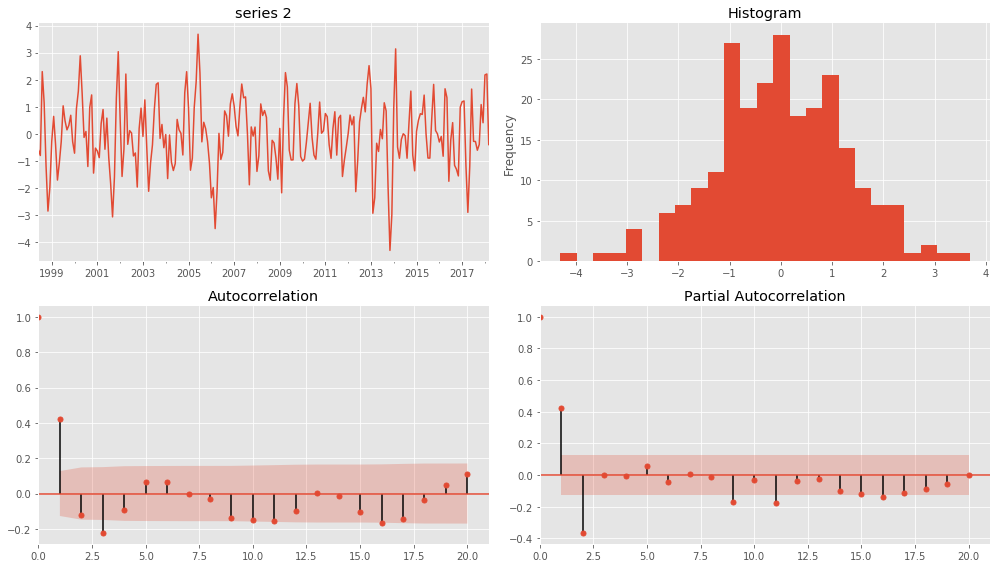

In [25]:
tsplot(series2_train, title='series 2', lags=20) 

In [26]:
train_results = sm.tsa.arma_order_select_ic(series2_train, ic=['aic', 'bic'], trend='nc', max_ar=4, max_ma=4)

print('AIC', train_results.aic_min_order)
print('BIC', train_results.bic_min_order)

AIC (1, 3)
BIC (2, 0)


In [27]:
ex3_mod = sm.tsa.statespace.SARIMAX(series2_train, order=(1,0,3))
ex3_arima_fit = ex3_mod.fit()
print(ex3_arima_fit.summary())

                           Statespace Model Results                           
Dep. Variable:                  value   No. Observations:                  238
Model:               SARIMAX(1, 0, 3)   Log Likelihood                -351.000
Date:                Mon, 27 May 2019   AIC                            712.001
Time:                        16:47:42   BIC                            729.362
Sample:                    06-01-1998   HQIC                           718.998
                         - 03-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7766      0.062     12.519      0.000       0.655       0.898
ma.L1         -0.2575      0.083     -3.119      0.002      -0.419      -0.096
ma.L2         -0.5291      0.064     -8.232      0.0

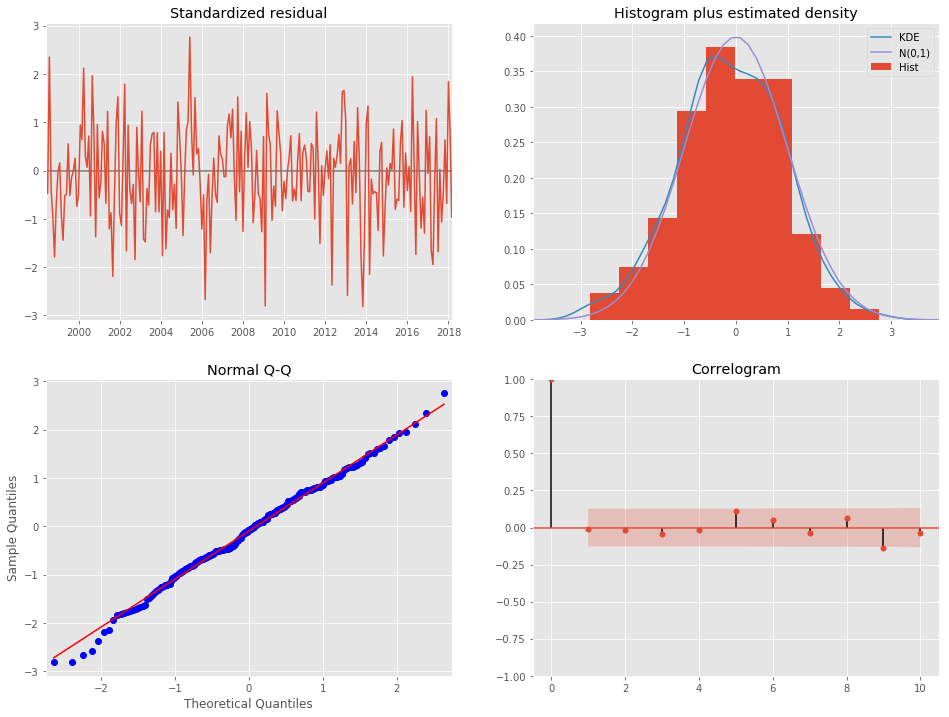

In [28]:
ex3_arima_fit.plot_diagnostics(figsize=(16, 12));

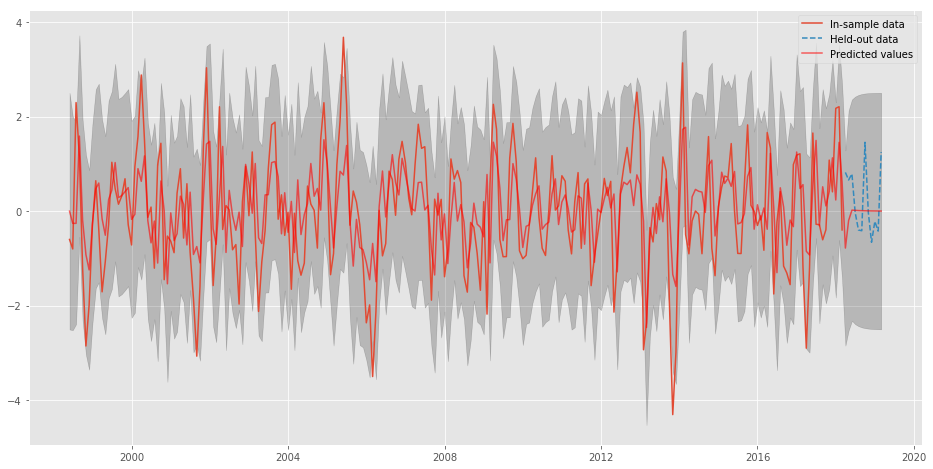

In [29]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(16, 8))
    
ax1.plot(series2_train, label='In-sample data', linestyle='-')
# subtract 1 only to connect it to previous point in the graph
ax1.plot(series2_test, label='Held-out data', linestyle='--')

# yes DatetimeIndex
pred_begin = series2_train.index[ex3_arima_fit.loglikelihood_burn]
pred_end = series2_test.index[-1]
pred = ex3_arima_fit.get_prediction(start=pred_begin.strftime('%Y-%m-%d'),
                                    end=pred_end.strftime('%Y-%m-%d'))
pred_mean = pred.predicted_mean
pred_ci = pred.conf_int(alpha=0.05)

ax1.plot(pred_mean, 'r', alpha=.6, label='Predicted values')
ax1.fill_between(pred_ci.index,
                 pred_ci.iloc[:, 0],
                 pred_ci.iloc[:, 1], color='k', alpha=.2)

ax1.legend(loc='best');

In [30]:
rmse = get_rmse(series2_test, pred_mean.ix[series2_test.index])
print(rmse)

mape = get_mape(series2_test, pred_mean.ix[series2_test.index])
print(mape)

mase = get_mase(series2_test, pred_mean.ix[series2_test.index])
print(mase)

0.845542989543726
118.67780889022634
1.1409421100793158
